## Imports

In [26]:
import os
import re
import sys

sys.path.append(
    os.path.join('..','src')
)

from src.models import NextWordPredictorModel
from src.data_processing import *

In [27]:
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import torch

In [28]:
import nltk

from nltk.corpus import webtext
# from nltk.tokenize import TweetTokenizer
from nltk.tokenize import sent_tokenize

## Global Variables

In [29]:
DEVICE = "cuda:0"
assert torch.cuda.is_available()
from apex import amp, optimizers

PADDING_TOKEN = 'PAD' # voc 0
UNKNOWN_TOKEN = 'UKN' # voc 1

max_sentence_length = 32
MAX_SEQ_LEN = 4

BATCH_SIZE = 16
EMB_SIZE = 256

val_split = 0.2
test_split = 0.1

# for reproducibility
# os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
torch.manual_seed(0)
np.random.seed(23)

## Vocabulary

In [30]:
class Vocabulary():
    def __init__(
        self, 
        sentences,
        padding_token : str = PADDING_TOKEN,
        unknown_token : str = UNKNOWN_TOKEN
    ):
        self.padding_token = padding_token
        self.unknown_token = unknown_token
        self.build_vocab(sentences)
    
    def build_vocab(self, sentences):
        vocab = {}
        for tokens in sentences:
            for token in tokens:
                if token in vocab.keys():
                    vocab[token] += 1
                else:
                    vocab[token] = 1

        self.vocab = {k: v for k, v in sorted(vocab.items(), key=lambda item: -item[1])}

        self.word_to_idx = {k : (i+2) for i,(k,_) in enumerate(vocab.items())}
        self.word_to_idx[self.padding_token] = 0
        self.word_to_idx[self.unknown_token] = 1
        self.idx_to_word = {v : k for k, v in self.word_to_idx.items()}
        
    def get_vocab_size(self):
        return len(voc.word_to_idx)
    
    def pad_and_truncate(self, tokens, max_length):
        diff = max_length - len(tokens)
        if diff < 0:
            return tokens[:max_length]
        else:
            return tokens + [self.word_to_idx[self.padding_token]] * diff
        
class LM_dataset(torch.utils.data.Dataset):
    def __init__(
        self,
        vocabulary : Vocabulary,
        sentences : list,
        max_length : int
    ):
        self.vocabulary = vocabulary
        self.max_length = max_length
        self.indices = [
            self.vocabulary.pad_and_truncate([self.get_idx(w) for w in sentence], max_length + 1)
            for sentence in sentences if len(sentence) > 1
        ]
        
    def get_idx(self, token):
        try:
            return self.vocabulary.word_to_idx[token]
        except KeyError:
            return self.vocabulary.word_to_idx[self.vocabulary.unknown_token]
        
    def __getitem__(self, idx):
        indices = self.indices[idx]
        return torch.tensor(indices[:self.max_length]).to(DEVICE)
        
    def __len__(self):
        return len(self.indices)

In [31]:
txt = webtext.raw('overheard.txt')
sentences = prepare_sentences(txt, max_sentence_length)
l = len(sentences)

In [7]:
indices = np.arange(len(sentences))
np.random.shuffle(indices)

test_indices = indices[:int(test_split * l)]
val_indices = indices[int(test_split * l):int(l * (test_split + val_split))]
train_indices = indices[int((test_split + val_split) * l):]

test_sentences = np.array(sentences, dtype = object)[test_indices]
val_sentences = np.array(sentences, dtype = object)[val_indices]
train_sentences = np.array(sentences, dtype = object)[train_indices]

In [8]:
voc = Vocabulary(sentences)

train_dataset = LM_dataset(
    voc,
    train_sentences,
    MAX_SEQ_LEN + 1
)
val_dataset = LM_dataset(
    voc,
    val_sentences,
    MAX_SEQ_LEN + 1
)
test_dataset = LM_dataset(
    voc,
    test_sentences,
    MAX_SEQ_LEN + 1
)

In [9]:
train_dataloader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size = BATCH_SIZE,
    shuffle = True,
    pin_memory = False,
    drop_last = True
)
val_dataloader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size = BATCH_SIZE,
    shuffle = False,
    pin_memory = False,
    drop_last = True
)

In [10]:
def map_weights(weights, m_ = 0.1, M_ = 1):
    weights = 1 / weights
    M, m = max(weights), min(weights)
    return (np.array(weights) - m) * (M_ - m_) / (M - m) + m_

In [11]:
weights = map_weights(np.array([1,1] + list(voc.vocab.values())))
#weights = None

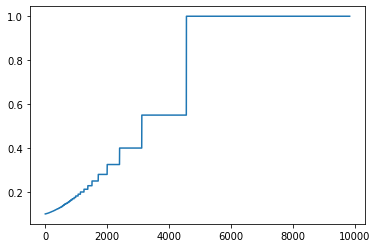

In [12]:
plt.plot(np.sort(weights))

In [13]:
model = NextWordPredictorModel(
    emb_dim  = EMB_SIZE,
    vocab_size = voc.get_vocab_size(),
    num_lstm_hidden_layers = 3,
    hidden_state_size = 200,
    dropout = 0.5,
    device = DEVICE,
    lr = 1e-2,
    fp16 = True,
    weight = weights
).to(DEVICE)

if model.fp16:
    model, model.optimizer = amp.initialize(
        model,
        model.optimizer,
        opt_level = 'O1' # https://nvidia.github.io/apex/amp.html
    )

Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic


In [14]:
metrics = model.fit(
    train_dataloader = train_dataloader,
    eval_dataloader = val_dataloader,
    num_epochs = 100,
    early_stopping = True,
    early_stopping_patience = 3,
    early_stopping_metric = 'val_loss',
    early_stopping_metric_best = 'min', # if lower is better (like for loss)
)

  3%|▎         | 18/713 [00:00<00:03, 174.18it/s]

Train loss at epoch 0 : 9.194676520948155
Eval loss at epoch 0 : 9.194585229836258
updating best metric


100%|██████████| 713/713 [00:03<00:00, 232.93it/s]
/home/potate/miniconda3/envs/typewriter/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:122: UserWarning: Seems like `optimizer.step()` has been overridden after learning rate scheduler initialization. Please, make sure to call `optimizer.step()` before `lr_scheduler.step()`. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Seems like `optimizer.step()` has been overridden after learning rate scheduler "
  3%|▎         | 24/713 [00:00<00:02, 238.43it/s]

Train loss at epoch 1 : 9.17973846205488
Eval loss at epoch 1 : 9.163500491310568
updating best metric


  3%|▎         | 24/713 [00:00<00:02, 238.13it/s]

Train loss at epoch 2 : 9.143867334844689
Eval loss at epoch 2 : 9.12271276174807
updating best metric


  3%|▎         | 24/713 [00:00<00:02, 235.10it/s]

Train loss at epoch 3 : 9.09124480457493
Eval loss at epoch 3 : 9.051762880063524
updating best metric


  3%|▎         | 24/713 [00:00<00:02, 235.14it/s]

Train loss at epoch 4 : 8.985078906611674
Eval loss at epoch 4 : 8.887869096269794
updating best metric


  3%|▎         | 24/713 [00:00<00:02, 237.48it/s]

Train loss at epoch 5 : 8.757906379405446
Eval loss at epoch 5 : 8.596034206596075
updating best metric


  3%|▎         | 24/713 [00:00<00:02, 233.67it/s]

Train loss at epoch 6 : 8.533495919734532
Eval loss at epoch 6 : 8.410787743680617
updating best metric


 55%|█████▍    | 389/713 [00:01<00:01, 233.23it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


  3%|▎         | 24/713 [00:00<00:02, 233.50it/s]

Train loss at epoch 7 : 8.386791100843089
Eval loss at epoch 7 : 8.290763471640792
updating best metric


  3%|▎         | 24/713 [00:00<00:02, 238.30it/s]

Train loss at epoch 8 : 8.291860694136226
Eval loss at epoch 8 : 8.217793361813415
updating best metric


  3%|▎         | 24/713 [00:00<00:02, 237.49it/s]

Train loss at epoch 9 : 8.222998359594573
Eval loss at epoch 9 : 8.172938578269061
updating best metric


 48%|████▊     | 343/713 [00:01<00:01, 233.18it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


  3%|▎         | 24/713 [00:00<00:02, 237.15it/s]

Train loss at epoch 10 : 8.168354320659878
Eval loss at epoch 10 : 8.142509409025603
updating best metric


  4%|▎         | 25/713 [00:00<00:02, 240.88it/s]

Train loss at epoch 11 : 8.124085025733851
Eval loss at epoch 11 : 8.119492865076252
updating best metric


  3%|▎         | 24/713 [00:00<00:02, 232.66it/s]

Train loss at epoch 12 : 8.099070886074243
Eval loss at epoch 12 : 8.101076235958175
updating best metric


 31%|███       | 218/713 [00:00<00:02, 235.01it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


  3%|▎         | 24/713 [00:00<00:02, 236.58it/s]

Train loss at epoch 13 : 8.065867962375764
Eval loss at epoch 13 : 8.086822694423152
updating best metric


  3%|▎         | 23/713 [00:00<00:03, 225.59it/s]

Train loss at epoch 14 : 8.040419580558574
Eval loss at epoch 14 : 8.07537068572699
updating best metric


  3%|▎         | 24/713 [00:00<00:02, 237.01it/s]

Train loss at epoch 15 : 8.018525125602519
Eval loss at epoch 15 : 8.066781261387993
updating best metric


 28%|██▊       | 197/713 [00:00<00:02, 240.36it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


  3%|▎         | 23/713 [00:00<00:03, 224.33it/s]

Train loss at epoch 16 : 7.99876682821865
Eval loss at epoch 16 : 8.059265155418247
updating best metric


  3%|▎         | 23/713 [00:00<00:03, 229.05it/s]

Train loss at epoch 17 : 7.9786152986791326
Eval loss at epoch 17 : 8.05412086318521
updating best metric


  3%|▎         | 23/713 [00:00<00:03, 227.27it/s]

Train loss at epoch 18 : 7.971675462174382
Eval loss at epoch 18 : 8.048727533396553
updating best metric


 65%|██████▌   | 464/713 [00:01<00:01, 239.98it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


  3%|▎         | 24/713 [00:00<00:02, 239.57it/s]

Train loss at epoch 19 : 7.949404776681523
Eval loss at epoch 19 : 8.044923370959712
updating best metric


  3%|▎         | 24/713 [00:00<00:02, 237.02it/s]

Train loss at epoch 20 : 7.9397863392074175
Eval loss at epoch 20 : 8.041771898082658
updating best metric


  3%|▎         | 24/713 [00:00<00:02, 237.14it/s]

Train loss at epoch 21 : 7.931596945913777
Eval loss at epoch 21 : 8.03969287404827
updating best metric


 85%|████████▌ | 609/713 [00:02<00:00, 240.98it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


  3%|▎         | 24/713 [00:00<00:02, 233.95it/s]

Train loss at epoch 22 : 7.9242209391707625
Eval loss at epoch 22 : 8.03856290321724
updating best metric


  3%|▎         | 24/713 [00:00<00:02, 237.02it/s]

Train loss at epoch 23 : 7.910148779774113
Eval loss at epoch 23 : 8.036508609266843
updating best metric


  3%|▎         | 24/713 [00:00<00:02, 236.08it/s]

Train loss at epoch 24 : 7.895328708316969
Eval loss at epoch 24 : 8.035853582270006
updating best metric


 34%|███▍      | 69/204 [00:00<00:00, 679.72it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


  3%|▎         | 23/713 [00:00<00:03, 226.51it/s]

Train loss at epoch 25 : 7.890213433355302
Eval loss at epoch 25 : 8.035659437086068
updating best metric


  3%|▎         | 24/713 [00:00<00:02, 237.32it/s]

Train loss at epoch 26 : 7.892119793537455
Eval loss at epoch 26 : 8.034603446137671
updating best metric


  3%|▎         | 22/713 [00:00<00:03, 215.37it/s]

Train loss at epoch 27 : 7.866863018667213
Eval loss at epoch 27 : 8.035064215753593


 91%|█████████ | 650/713 [00:02<00:00, 237.91it/s]

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 131072.0


  3%|▎         | 24/713 [00:00<00:02, 235.29it/s]

Train loss at epoch 28 : 7.8719159650601975
Eval loss at epoch 28 : 8.034910230075612


100%|██████████| 204/204 [00:00<00:00, 745.57it/s]

Train loss at epoch 29 : 7.8668927490962
Eval loss at epoch 29 : 8.035195612439923
early stopping, patience: 3, loading best epoch: 26.


In [15]:
metrics

{0: {'train_loss': 9.194676520948155,
  'val_loss': 9.194585229836258,
  'lr': 0.01},
 1: {'train_loss': 9.17973846205488,
  'val_loss': 9.163500491310568,
  'lr': 0.0099},
 2: {'train_loss': 9.143867334844689,
  'val_loss': 9.12271276174807,
  'lr': 0.009801},
 3: {'train_loss': 9.09124480457493,
  'val_loss': 9.051762880063524,
  'lr': 0.00970299},
 4: {'train_loss': 8.985078906611674,
  'val_loss': 8.887869096269794,
  'lr': 0.0096059601},
 5: {'train_loss': 8.757906379405446,
  'val_loss': 8.596034206596075,
  'lr': 0.009509900499},
 6: {'train_loss': 8.533495919734532,
  'val_loss': 8.410787743680617,
  'lr': 0.00941480149401},
 7: {'train_loss': 8.386791100843089,
  'val_loss': 8.290763471640792,
  'lr': 0.0093206534790699},
 8: {'train_loss': 8.291860694136226,
  'val_loss': 8.217793361813415,
  'lr': 0.0092274469442792},
 9: {'train_loss': 8.222998359594573,
  'val_loss': 8.172938578269061,
  'lr': 0.009135172474836408},
 10: {'train_loss': 8.168354320659878,
  'val_loss': 8.14

In [21]:
sent = 'so how are'
ind = [voc.word_to_idx[w] for w in sent.split(' ')]
print(ind)
hidden = model.init_hidden(1)
inputs = torch.tensor([ind]).to(DEVICE)
model.eval()
output, hidden = model(inputs, hidden)
preds = output.view(-1, model.vocab_size)

[2, 117, 72]


In [22]:
for i in preds.topk(1)[1].view(-1):
    w = voc.idx_to_word[i.item()]
    print(w)

you
you
you


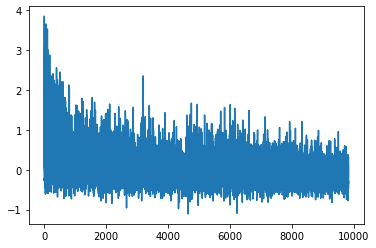

In [23]:
a = output[0][0].detach().to('cpu').numpy()
plt.plot(a)

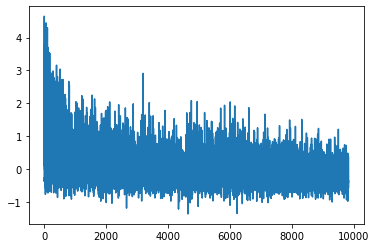

In [24]:
a = output[0][1].detach().to('cpu').numpy()
plt.plot(a)

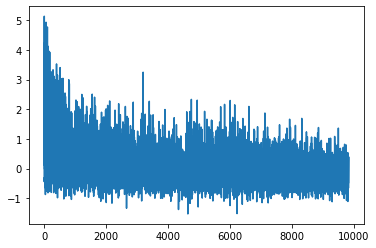

In [25]:
a = output[0][2].detach().to('cpu').numpy()
plt.plot(a)

In [1]:
import math
from typing import Tuple

import torch
from torch import nn, Tensor
import torch.nn.functional as F
from torch.nn import TransformerEncoder, TransformerEncoderLayer, RNN, LSTM
from torch.utils.data import dataset

In [40]:
class Model(nn.Module):
    def __init__(
        self, 
        ntoken: int,
        emb_dim: int,
        nhead: int,
        hidden_state_size: int,
        num_hidden_layers: int, 
        dropout: float = 0.5,
        type_of_model : str = 'Transformer'
    ):
        super().__init__()
        self.type_of_model = type_of_model
        self.emb_dim = emb_dim
        
        self.encoder = nn.Embedding(ntoken, emb_dim)
        self.pos_encoder = PositionalEncoding(emb_dim, dropout)
        if type_of_model == 'Transformer':
            encoder_layers = TransformerEncoderLayer(emb_dim, nhead, hidden_state_size, dropout)
            self.transform = TransformerEncoder(encoder_layers, num_hidden_layers)
        elif type_of_model == 'RNN':
            self.transform = RNN(
                input_size = emb_dim,
                hidden_size = hidden_state_size,
                num_layers = num_hidden_layers,
                dropout = dropout,
                batch_first = True # -> input of the shape (bath size, seq length, emb length)
            )
        else:
            print('model must be one of Transformer, LSTM')
        self.decoder = nn.Linear(emb_dim, ntoken)

        self.init_weights()

    def init_weights(self) -> None:
        initrange = 0.1
        self.encoder.weight.data.uniform_(-initrange, initrange)
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)
            

    def forward(self, src: Tensor, hidden: Tensor) -> Tensor:
        """
        Args:
            src: Tensor, shape [seq_len, batch_size]
            src_mask: Tensor, shape [seq_len, seq_len]

        Returns:
            output Tensor of shape [seq_len, batch_size, ntoken]
        """
        src = self.encoder(src) * math.sqrt(self.emb_dim)
        src = self.pos_encoder(src)
        if self.type_of_model == 'Transformer':
            output = self.transform(src, hidden)
        elif self.type_of_model == 'RNN':
            output, hidden = self.transform(src, hidden.detach())
        output = self.decoder(output)
        return output, hidden

def generate_hidden(
    sz: int,
    type_of_model: str
) -> Tensor:
    if type_of_model == 'Transformer':
        """Generates an upper-triangular matrix of -inf, with zeros on diag."""
        return torch.triu(torch.ones(sz, sz) * float('-inf'), diagonal=1)
    elif type_of_model == 'RNN':
        return torch.zeros(2, sz, 200)

class PositionalEncoding(nn.Module):
    def __init__(
        self,
        emb_dim: int,
        dropout: float = 0.1,
        max_len: int = 5000
    ):
        """
        Class of a nn.Module that add a positional encoding to the embedding
        """
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, emb_dim, 2) * (-math.log(10000.0) / emb_dim))
        pe = torch.zeros(max_len, 1, emb_dim)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: Tensor) -> Tensor:
        """
        Args:
            x: Tensor, shape [seq_len, batch_size, embedding_dim]
        """
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)


In [41]:
from torchtext.datasets import WikiText2
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

train_iter = WikiText2(split='train')
tokenizer = get_tokenizer('basic_english')
vocab = build_vocab_from_iterator(map(tokenizer, train_iter), specials=['<unk>'])
vocab.set_default_index(vocab['<unk>'])

def data_process(raw_text_iter: dataset.IterableDataset) -> Tensor:
    """Converts raw text into a flat Tensor."""
    data = [torch.tensor(vocab(tokenizer(item)), dtype=torch.long) for item in raw_text_iter]
    return torch.cat(tuple(filter(lambda t: t.numel() > 0, data)))

# train_iter was "consumed" by the process of building the vocab,
# so we have to create it again
train_iter, val_iter, test_iter = WikiText2()
train_data = data_process(train_iter)
val_data = data_process(val_iter)
test_data = data_process(test_iter)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def batchify(data: Tensor, bsz: int) -> Tensor:
    """Divides the data into bsz separate sequences, removing extra elements
    that wouldn't cleanly fit.

    Args:
        data: Tensor, shape [N]
        bsz: int, batch size

    Returns:
        Tensor of shape [N // bsz, bsz]
    """
    seq_len = data.size(0) // bsz
    data = data[:seq_len * bsz]
    data = data.view(bsz, seq_len).t().contiguous()
    return data.to(device)

batch_size = 20
eval_batch_size = 10
train_data = batchify(train_data, batch_size)  # shape [seq_len, batch_size]
val_data = batchify(val_data, eval_batch_size)
test_data = batchify(test_data, eval_batch_size)

In [42]:
bptt = 35
def get_batch(source: Tensor, i: int) -> Tuple[Tensor, Tensor]:
    """
    Args:
        source: Tensor, shape [full_seq_len, batch_size]
        i: int

    Returns:
        tuple (data, target), where data has shape [seq_len, batch_size] and
        target has shape [seq_len * batch_size]
    """
    seq_len = min(bptt, len(source) - 1 - i)
    data = source[i:i+seq_len]
    target = source[i+1:i+1+seq_len].reshape(-1)
    return data, target

In [43]:
ntokens = len(vocab)  # size of vocabulary
emsize = 200  # embedding dimension
d_hid = 200  # dimension of the feedforward network model in nn.TransformerEncoder
nlayers = 2  # number of nn.TransformerEncoderLayer in nn.TransformerEncoder
nhead = 2  # number of heads in nn.MultiheadAttention
dropout = 0.2  # dropout probability
model = Model(
    ntokens,
    emsize,
    nhead,
    d_hid,
    nlayers,
    dropout,
    'RNN'
).to(device)

In [44]:
import copy
import time

criterion = nn.CrossEntropyLoss()
lr = 5.0  # learning rate
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.95)

def train(model: nn.Module) -> None:
    model.train()  # turn on train mode
    total_loss = 0.
    log_interval = 200
    start_time = time.time()
    hidden = generate_hidden(bptt, model.type_of_model).to(device)

    num_batches = len(train_data) // bptt
    for batch, i in enumerate(range(0, train_data.size(0) - 1, bptt)):
        data, targets = get_batch(train_data, i)
        batch_size = data.size(0)
        if batch_size != bptt:  # only on last batch
            if model.type_of_model == 'Transformer':
                hidden = hidden[:batch_size, :batch_size]
            elif model.type_of_model == 'RNN':
                continue
        output, hidden = model(data, hidden)
        loss = criterion(output.view(-1, ntokens), targets)

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()

        total_loss += loss.item()
        if batch % log_interval == 0 and batch > 0:
            lr = scheduler.get_last_lr()[0]
            ms_per_batch = (time.time() - start_time) * 1000 / log_interval
            cur_loss = total_loss / log_interval
            ppl = math.exp(cur_loss)
            print(f'| epoch {epoch:3d} | {batch:5d}/{num_batches:5d} batches | '
                  f'lr {lr:02.2f} | ms/batch {ms_per_batch:5.2f} | '
                  f'loss {cur_loss:5.2f} | ppl {ppl:8.2f}')
            total_loss = 0
            start_time = time.time()

def evaluate(model: nn.Module, eval_data: Tensor) -> float:
    model.eval()  # turn on evaluation mode
    total_loss = 0.
    hidden = generate_hidden(bptt, model.type_of_model).to(device)
    with torch.no_grad():
        for i in range(0, eval_data.size(0) - 1, bptt):
            data, targets = get_batch(eval_data, i)
            batch_size = data.size(0)
            if batch_size != bptt:  # only on last batch
                if model.type_of_model == 'Transformer':
                    hidden = hidden[:batch_size, :batch_size]
                elif model.type_of_model == 'RNN':
                    hidden = hidden[:, :batch_size, :]
            output = model(data, hidden)
            output_flat = output.view(-1, ntokens)
            total_loss += batch_size * criterion(output_flat, targets).item()
    return total_loss / (len(eval_data) - 1)

In [45]:
best_val_loss = float('inf')
epochs = 3
best_model = None

for epoch in range(1, epochs + 1):
    epoch_start_time = time.time()
    train(model)
    val_loss = evaluate(model, val_data)
    val_ppl = math.exp(val_loss)
    elapsed = time.time() - epoch_start_time
    print('-' * 89)
    print(f'| end of epoch {epoch:3d} | time: {elapsed:5.2f}s | '
          f'valid loss {val_loss:5.2f} | valid ppl {val_ppl:8.2f}')
    print('-' * 89)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = copy.deepcopy(model)

    scheduler.step()

| epoch   1 |   200/ 2928 batches | lr 5.00 | ms/batch  9.48 | loss  8.19 | ppl  3620.70
| epoch   1 |   400/ 2928 batches | lr 5.00 | ms/batch  9.24 | loss  6.96 | ppl  1054.33
| epoch   1 |   600/ 2928 batches | lr 5.00 | ms/batch  9.16 | loss  6.58 | ppl   717.47
| epoch   1 |   800/ 2928 batches | lr 5.00 | ms/batch  9.19 | loss  6.46 | ppl   641.11
| epoch   1 |  1000/ 2928 batches | lr 5.00 | ms/batch  9.27 | loss  6.38 | ppl   587.49
| epoch   1 |  1200/ 2928 batches | lr 5.00 | ms/batch  9.20 | loss  6.35 | ppl   575.02
| epoch   1 |  1400/ 2928 batches | lr 5.00 | ms/batch  9.19 | loss  6.32 | ppl   554.87
| epoch   1 |  1600/ 2928 batches | lr 5.00 | ms/batch  9.21 | loss  6.30 | ppl   542.72
| epoch   1 |  1800/ 2928 batches | lr 5.00 | ms/batch  9.21 | loss  6.23 | ppl   507.15
| epoch   1 |  2000/ 2928 batches | lr 5.00 | ms/batch  9.19 | loss  6.24 | ppl   510.64
| epoch   1 |  2200/ 2928 batches | lr 5.00 | ms/batch  9.20 | loss  6.12 | ppl   455.06
| epoch   1 |  2400/ 

AttributeError: 'tuple' object has no attribute 'view'

In [ ]:
test_loss = evaluate(best_model, test_data)
test_ppl = math.exp(test_loss)
print('=' * 89)
print(f'| End of training | test loss {test_loss:5.2f} | '
      f'test ppl {test_ppl:8.2f}')
print('=' * 89)